In [ ]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#https://github.com/amueller/word_cloud
import random

import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import regex as re
from collections import Counter

#So I can see multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
#Load the extra clean data
df = pd.read_csv('recipe_overclean.csv', sep = ",", quotechar = '"', dtype=object, index_col=0)
df["TotalIng"] = pd.to_numeric(df["TotalIng"])

In [ ]:
df.sample(2)

In [ ]:
#View some summary data by website
agg1 = df.groupby("Website").size()
agg2 = 76 - df.groupby('Website')[["TotalIng"]].mean()
website = pd.concat([agg1, agg2], axis=1, sort=False)
website.rename(columns={0: 'NumRecipes', 'TotalIng': 'AveNumIngr'}, inplace=True)
website

In [ ]:
# Summary statistic of each website's recipes
wb_topsum = website.sort_values(by='NumRecipes',ascending=False).head(20)
wb_topave = website.sort_values(by='AveNumIngr',ascending=False).head(20)

In [ ]:
#View the reason we are only going to look at the top websites for the below visualization
wb_topsum
wb_topave

In [ ]:
plt.figure(figsize=(15,10))
wb_topsum.NumRecipes.sort_values(ascending=False).plot.bar()

plt.xticks(rotation=50)
plt.title('Number of Recipes per top 20 Sites')
plt.xlabel("Website of Origin")
plt.ylabel("Number of Recipes")
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
wb_topsum.AveNumIngr.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Average Number of Ingredients per Recipe in top 20 Sites')
plt.xlabel("Website of Origin")
plt.ylabel("Average Number of Ingredients")
plt.show()

In [ ]:
#Read in 
ingredients = pd.read_csv('ingredients_agg.csv', names = ['Title','AggIngredients'], sep = ",", quotechar = '"', skipinitialspace=True, error_bad_lines = False, dtype=object)

#Cleanup separate commas, all lowercase, stem select words
ingredients.Title = ingredients.Title.str.replace(',',' , ')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace(',',' , ')
ingredients.Title = ingredients.Title.str.replace('(',' ')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('(',' ')
ingredients.Title = ingredients.Title.str.replace(')',' ')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace(')',' ')

ingredients.Title = ingredients.Title.str.lower()
ingredients.AggIngredients = ingredients.AggIngredients.str.lower()

ingredients.Title = ingredients.Title.str.replace('nan',' ')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('nan',' ')

ingredients.Title = ingredients.Title.str.replace('potatoes','potato')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('potatoes','potato')
ingredients.Title = ingredients.Title.str.replace('potatoes','potato')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('tomatoes','tomato')
ingredients.Title = ingredients.Title.str.replace('eggs','egg')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('eggs','egg')
#regex? clove * garlic, garlic clove
ingredients.Title = ingredients.Title.str.replace('garlic clove','garlic')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('garlic clove','garlic')
ingredients.Title = ingredients.Title.str.replace('cloves of garlic','garlic')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('cloves of garlic','garlic')
ingredients.Title = ingredients.Title.str.replace('clove of garlic','garlic')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('clove of garlic','garlic')

#!?


ingredients.to_csv(path_or_buf = f'ingredients_agg.csv', header = False)

In [ ]:
ingredients.AggIngredients.head()

In [ ]:
wordfreq_Title = ingredients.Title.apply(lambda x: pd.value_counts(str(x).split(" "))).sum(axis = 0)

In [ ]:
wordfreq_Title = wordfreq_Title[3:]

In [ ]:
#Make me a pickle

In [ ]:
wordfreq_AggIng = ingredients.AggIngredients.apply(lambda x: pd.value_counts(str(x).split(" "))).sum(axis = 0)

In [ ]:
wordfreq_AggIng = wordfreq_AggIng[4:]

In [ ]:
#View word count on Recipe Title
plt.figure(figsize=(15,10))
wordfreq_Title.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Word Frequency in Recipe Titles')
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.ylim(top = 1000)
plt.show()


Ridiculous, the code takes a long time and the resulting graph is not very readable due to a large number of datapoints.  Let's look at a smaller data set.

In [ ]:
wordfreq_Title_top = wordfreq_Title.sort_values(ascending=False).head(50)
wordfreq_Title_top

In [ ]:
plt.figure(figsize=(15,10))
wordfreq_Title_top.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Word Frequency in Recipe Titles')
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

In [ ]:
wordfreq_Ing_top = wordfreq_AggIng.sort_values(ascending=False).head(50)
wordfreq_Ing_top

In [ ]:
plt.figure(figsize=(15,10))
wordfreq_Ing_top.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Word Frequency in Recipe Ingredients')
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

There's a lot of high frequency, irrelevant words.  Remove the stopwords.  In a future version of this, all verbs would be removed as a collective.

In [ ]:
# Create stopword list:
stopwords = set(STOPWORDS)
stop1 = ['a', 'and', 'the', 'or', 'of', 'if', 'on', 'but','with','®',
        'pinch', 'left', '&',
        'small', 'medium', 'large', 'whole', 'into', 'in', 'to',
        'plus', 'more', 'thick', 'halved', 'quartered', 'good',
        'inch', 'inches', 'about', 'sea', 'end', 'approximate',
        'approximately', 'very', 'finely', 'for', 'nan', 'none', 
         'peeled', 'cut', 'chopped', 'sliced','ground',
         'recipe', 'freshly']
measurement = ['teaspoon', 'tsp', 'tablespoon', 'tbsp','sprigs','sprig',
               'teaspoons', 'tablespoons', 
                'ounce', 'oz', 'cup', 'pint', 'pt', 
                'ounces', 'cups', 'pints',
                'quart', 'qt', 'gallon', 'gal',
                'quarts', 'gallons',
               'pound', 'lb', 'gram', 'kilogram',
               'pounds', 'lbs', 'grams', 'kilograms',
                'milliliter', 'liter', 'weight',
                'milliliters', 'liters']
amounts = ["1", "one", "2", "two", "3", 'three','4','four',
           '5','five','6','six','7','seven','8','eight','9',
           'nine','10','ten','½', '1/2','half', '1½','¼','1/4','3/4','⅓','1/3','¾','1-½','12']
stopwords.update(stop1,measurement,amounts)

In [ ]:
#Remove stopwords 
wordfreq_AggIng = wordfreq_AggIng[~wordfreq_AggIng.index.isin(stopwords)]
wordfreq_Title = wordfreq_Title[~wordfreq_Title.index.isin(stopwords)]

In [ ]:
wordfreq_Title_top = wordfreq_Title.sort_values(ascending=False).head(50)
wordfreq_Title_top
wordfreq_Ing_top = wordfreq_AggIng.sort_values(ascending=False).head(50)
wordfreq_Ing_top

With a large set of stopwords removed from the analysis, the graphs are more relevant.

In [ ]:
plt.figure(figsize=(15,10))
wordfreq_Title_top.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Word Frequency in Recipe Title (w/o StopWords)')
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
wordfreq_Ing_top.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Word Frequency of Recipe Ingredients (w/o StopWords)')
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

Looking through the x-axis, there are several more stopwords which could be added if one wanted to see only ingredients.  The following updated list causes several false correlations, such as bell pepper and black pepper.  In future iterations of this project, the concept of bigrams would be explored to get more accurate analysis.

In [ ]:
#Remove adj and verbs
stopwordsExtra = stopwords.copy()
stopwordsExtra.update(['fresh','black','red','powder','minced','white',
                       'grated','kosher','unsalted','leaves','sauce','baking',
                      'dried','diced','thinly','extract','divided','brown','pieces',
                      'green','taste','slices','seeds','dry','room','temperature',
                      'all-purpose','shredded','crushed','drained','coarsely',
                      'heavy','frozen','granulated','melted','softened','trimmed',
                       'toasted','yellow','removed','cubes','cooked','light','seeded','powdered'])

In [ ]:
wordfreq_AggIng = wordfreq_AggIng[~wordfreq_AggIng.index.isin(stopwordsExtra)]
wordfreq_Ing_top = wordfreq_AggIng.sort_values(ascending=False).head(50)
wordfreq_Ing_top

In [ ]:
plt.figure(figsize=(15,10))
wordfreq_Ing_top.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Word Frequency of Recipe Ingredients (w/o Extra StopWords)')
plt.xlabel("Ingredient")
plt.ylabel("Frequency")
plt.show()

It may be interesting to view the above graph of ingredient frequencies as a proportion over the total number of recipes.  For example, salt is an ingredient in about 75% of the scraped recipes.

In [ ]:
wordfreq_Ing_prop = wordfreq_AggIng.sort_values(ascending=False).head(50)/len(df)
wordfreq_Ing_prop.head(5)

In [ ]:
plt.figure(figsize=(15,10))
wordfreq_Ing_prop.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Proportion of Recipes containing given Ingredient')
plt.xlabel("Word")
plt.ylabel("Proportion")
plt.show()

 # WordClouds

In [1]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#https://github.com/amueller/word_cloud
import random

import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import regex as re
from collections import Counter

#So I can see multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#Incase I need to reload
ingredients = pd.read_csv('ingredients_agg.csv', names = ['Title','AggIngredients'], sep = ",", quotechar = '"', skipinitialspace=True, error_bad_lines = False, dtype=object)
# wordfreq_Title = ingredients.Title.apply(lambda x: pd.value_counts(str(x).split(" "))).sum(axis = 0)
# wordfreq_Title = wordfreq_Title[3:]
# wordfreq_AggIng = ingredients.AggIngredients.apply(lambda x: pd.value_counts(str(x).split(" "))).sum(axis = 0)
# wordfreq_AggIng = wordfreq_AggIng[4:]

In [3]:
# Create stopword list:
stopwords = set(STOPWORDS)
stop1 = ['a', 'and', 'the', 'or', 'of', 'if', 'on', 'but','with','®',
        'pinch', 'left', '&',
        'small', 'medium', 'large', 'whole', 'into', 'in', 'to',
        'plus', 'more', 'thick', 'halved', 'quartered', 'good',
        'inch', 'inches', 'about', 'end', 'approximate',
        'approximately', 'very', 'finely', 'for', 'nan', 'none', 
         'recipe', 'freshly']
measurement = ['teaspoon', 'tsp', 'tablespoon', 'tbsp','sprigs','sprig',
               'teaspoons', 'tablespoons', 
                'ounce', 'oz', 'cup', 'pint', 'pt', 
                'ounces', 'cups', 'pints',
                'quart', 'qt', 'gallon', 'gal',
                'quarts', 'gallons',
               'pound', 'lb', 'gram', 'kilogram',
               'pounds', 'lbs', 'grams', 'kilograms',
                'milliliter', 'liter', 'weight',
                'milliliters', 'liters']
amounts = ["1", "one", "2", "two", "3", 'three','4','four',
           '5','five','6','six','7','seven','8','eight','9',
           'nine','10','ten','½', '1/2','half', '1½','¼','1/4','3/4','⅓','1/3','¾','1-½','12']
stopwords.update(stop1,measurement,amounts)

stopwordsExtra = stopwords.copy()
stopwordsExtra.update(['sea', 'fresh','black','red','powder','minced','white',
                        'peeled', 'cut', 'chopped', 'sliced','ground',                       
                       'grated','kosher','unsalted','leaves','sauce','baking',
                      'dried','diced','thinly','extract','divided','brown','pieces',
                      'green','taste','slices','seeds','dry','room','temperature',
                      'all-purpose','shredded','crushed','drained','coarsely',
                      'heavy','frozen','granulated','melted','softened','trimmed',
                       'toasted','yellow','removed','cubes','cooked','light','seeded','powdered'])

In [22]:
def wc(site,section, pic=None):
    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopwords, width=1600, height=800, contour_width=2, contour_color='white',
                          mask=pic, colormap='Pastel1', 
                        regexp = r"\w[\w'-]+").generate(ingredients.loc[site,section])
    # Display the generated image:
    # the matplotlib way:
    plt.figure( figsize=(20,10) )
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    wordcloud.to_file("img/FoodNetTitle.png")

In [5]:
food_mask = np.array(Image.open("Img/CoveredHotPlate.jpg"))
chicken_mask = np.array(Image.open("Img/Chicken.jpg"))
sp_mask = np.array(Image.open("Img/SandP.png"))
bowl_mask = np.array(Image.open("Img/Bowl2.png"))
cake_mask = np.array(Image.open("Img/Cake3.png"))

In [ ]:
cake_mask = np.array(Image.open("Img/Cake2.png"))
cake_mask
# bowl_mask_trans[35]

In [17]:
#swap number 0 to 255
def transform_format(val):
    if val == 255:
        return 255
    else:
        return 1

In [28]:
#Sometimes the mask needs to be transformed?
#Transform your mask into a new one that will work with the function:
sp_mask_trans = np.ndarray((sp_mask.shape[0],sp_mask.shape[1]), np.int32)

for i in range(len(sp_mask)):
    for j in range(len(sp_mask[i])):
        sp_mask_trans[i][j] = transform_format(sp_mask[i][j])

In [50]:
#Sometimes the mask needs to be transformed?
#Transform your mask into a new one that will work with the function:
bowl_mask_trans = np.ndarray((bowl_mask.shape[0],bowl_mask.shape[1]), np.int32)

for i in range(len(bowl_mask)):
    for j in range(len(bowl_mask[i])):
        bowl_mask_trans[i][j] = transform_format(bowl_mask[i][j])

In [18]:
#Sometimes the mask needs to be transformed?
#Transform your mask into a new one that will work with the function:
cake_mask_trans = np.ndarray((cake_mask.shape[0],cake_mask.shape[1],cake_mask.shape[2]), np.int32)

for i in range(len(cake_mask)):
    for j in range(len(cake_mask[i])):
        for k in range(len(cake_mask[i][j])):
            cake_mask_trans[i][j][k] = transform_format(cake_mask[i][j][k])

In [ ]:
wb_topsum

In [81]:
from IPython.display import display, HTML
CSS = """
.output {
    flex-direction: row;
}
"""
#div.cell:nth-child(5) 
HTML('<style>{}</style>'.format(CSS))

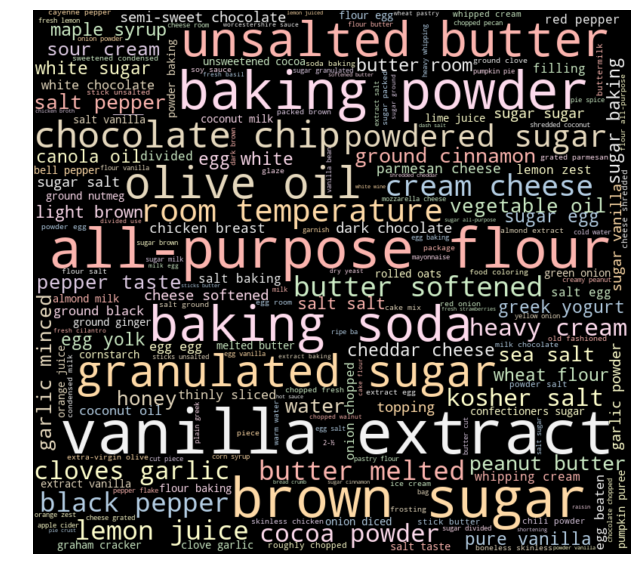

In [19]:
# wc('tastykitchen','Title', cake_mask_trans)
wc('tastykitchen','AggIngredients', cake_mask_trans)

In [102]:
# wc('tastykitchen')
ingredients.loc['tastykitchen',['Title','AggIngredients']]

Title             10-minute bruschetta ,  10-minute tapenade ,  ...
AggIngredients    1 pint cherry tomato ,  quartered or diced ,  ...
Name: tastykitchen, dtype: object

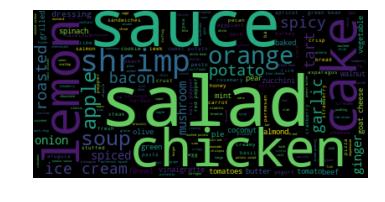

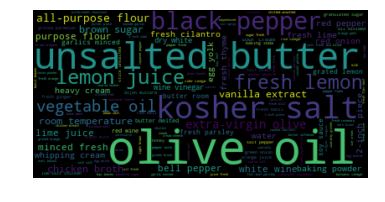

In [83]:
wc('epicurious','Title')
wc('epicurious','AggIngredients')

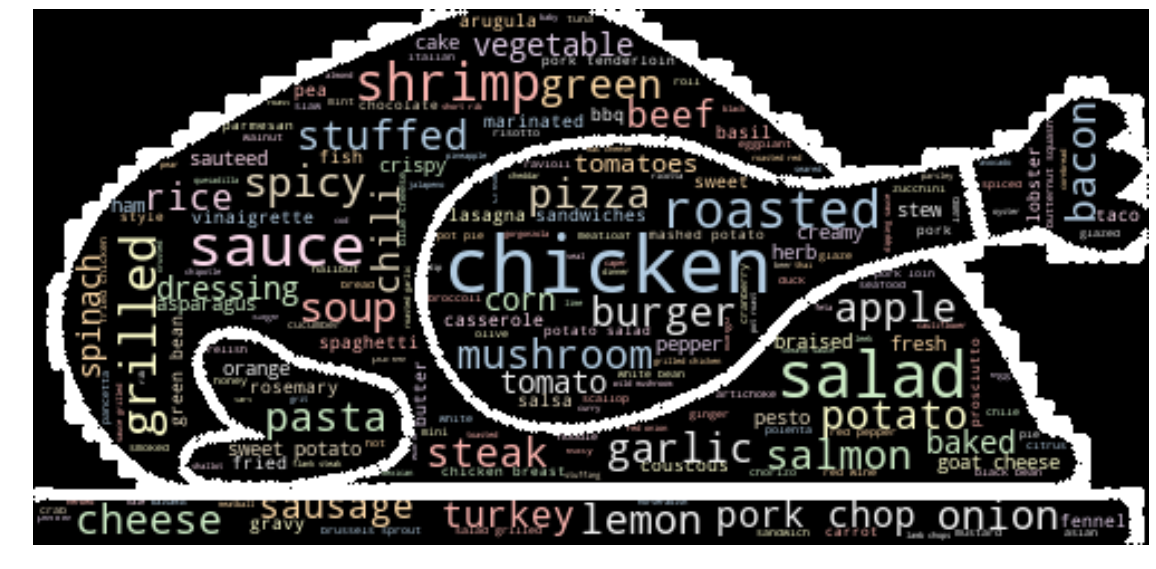

In [23]:
wc('foodnetwork','Title', chicken_mask)

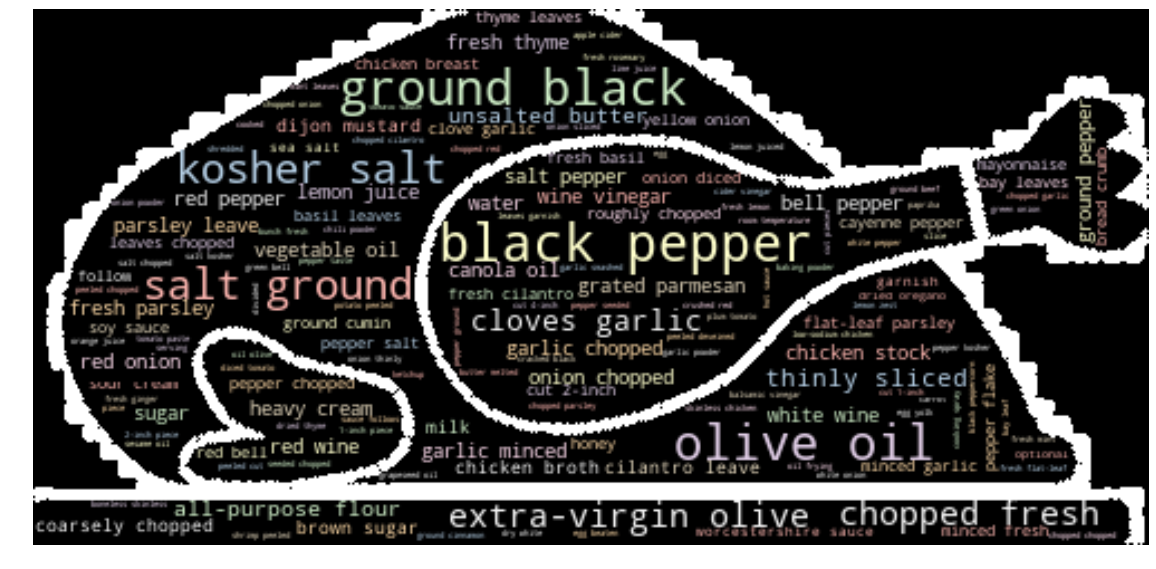

In [21]:
wc('foodnetwork','AggIngredients', chicken_mask)

In [ ]:
def brown_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(16, 100%%, %d%%)" % random.randint(0, 50)

Text(0.5, 1.0, 'Custom colors')

NameError: name 'brown_color_func' is not defined

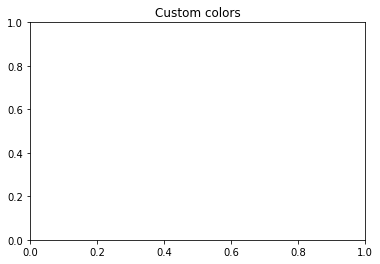

In [60]:
wc = WordCloud(max_words=1000, background_color="white", mask=chicken_mask, stopwords=stopwords, margin=10, 
               contour_width=2, contour_color='saddlebrown',random_state=1).generate(ingredients.loc['foodnetwork','Title'])
# store default colored image
default_colors = wc.to_array()
plt.title("Custom colors")
plt.imshow(wc.recolor(color_func=brown_color_func, random_state=3), interpolation="bilinear")
# wc.to_file("fn.png")
# plt.axis("off")
# plt.figure()
# plt.title("Default colors")
# plt.imshow(default_colors, interpolation="bilinear")
# plt.axis("off")
# plt.show()

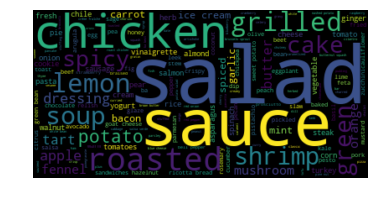

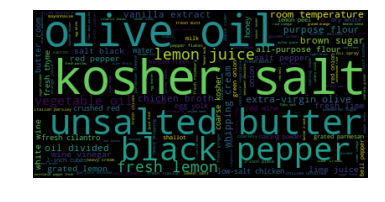

In [85]:
wc('bonappetit','Title')
wc('bonappetit','AggIngredients')

In [59]:
wc('bonappetit','Title',food_mask)

NameError: name 'wc' is not defined

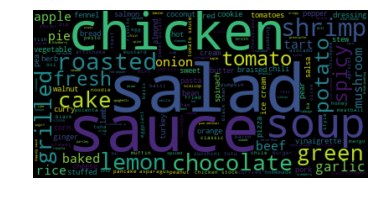

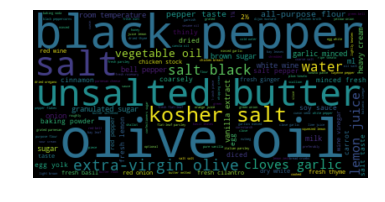

In [84]:
wc('cookstr','Title')
wc('cookstr', 'AggIngredients')

In [ ]:
ingredients['Title'].str.cat()

(-0.5, 280.5, 178.5, -0.5)

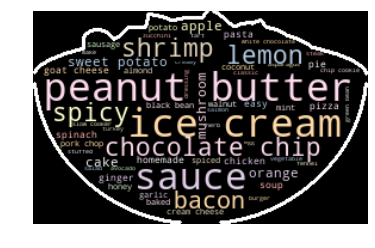

In [51]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, #background_color="white",
                      width=1600, height=800, contour_width=2, contour_color='white',
                      mask=bowl_mask_trans, colormap='Pastel1', regexp = r"\w[\w'-]+").generate(ingredients['Title'].str.cat())
# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# wordcloud.to_file("img/AllIng.png")

<Figure size 1440x720 with 0 Axes>

(-0.5, 280.5, 178.5, -0.5)

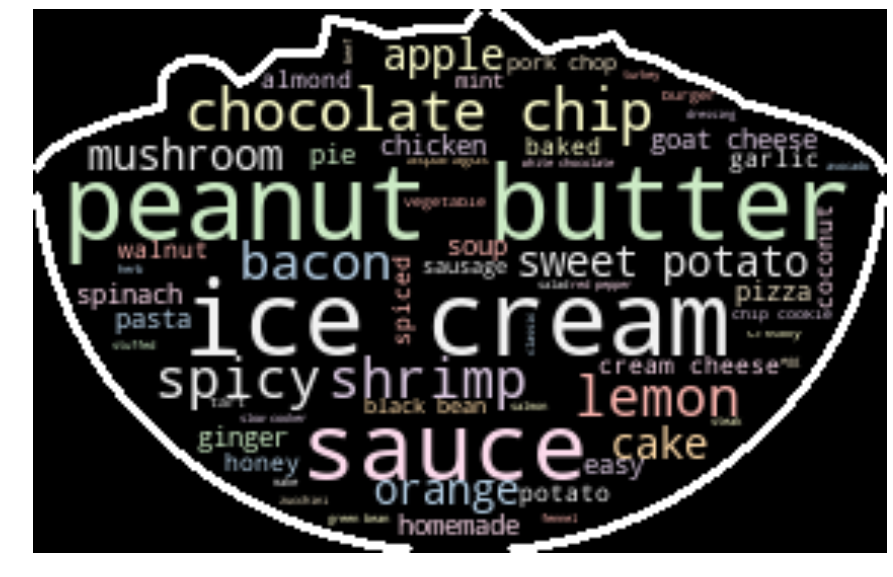

In [57]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, #background_color="white",
                      width=1600, height=800, contour_width=2, contour_color='white',
                      mask=bowl_mask_trans, colormap='Pastel1', regexp = r"\w[\w'-]+").generate(ingredients['Title'].str.cat())
# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("img/AllTitle.png")

<Figure size 1440x720 with 0 Axes>

(-0.5, 224.5, 224.5, -0.5)

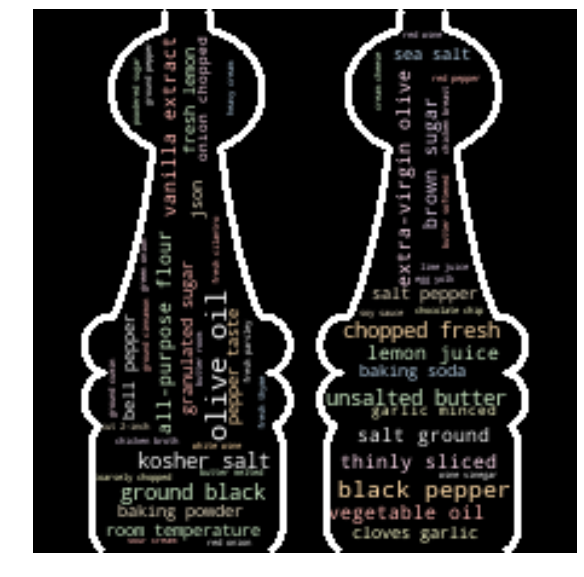

In [58]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, #background_color="white",
                      width=1600, height=800, contour_width=2, contour_color='white',
                      mask=sp_mask_trans, colormap='Pastel1', regexp = r"\w[\w'-]+").generate(ingredients['AggIngredients'].str.cat())
# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# Save the image in the img folder:
wordcloud.to_file("img/AllIng.png")

This dataset started its life on a various recipe database websites.  Through webscraper code, utilizing BeautifulSoup and open source code as a base, the initial csv of 155,876 lines listed the url, recipe title, total time, and each ingredient as a separate column.  Recipe titles or ingredients which internally contained commas were surrounded by double quotes.

The recipe scraper provides ingredients as they are written within the websites. We will need to parse out the amounts from the ingredients themselves and occasionally additional instructions. (1 10-oz. package frozen blackberries (about 2 cups), thawed) (2 large fresh fennel bulbs, trimmed, each cut vertically into 12 wedges with some core attached) The amounts and the ingredients will need to be normalized to merge with the nutritional dataset.

In [ ]:
df = pd.read_csv('recipe_overclean.csv', sep = ",", quotechar = '"', dtype=object, index_col=0)
df["TotalIng"] = pd.to_numeric(df["TotalIng"])#This actually is num of nan

# Copy dataframe and group by recipe
NumRecipes = len(df)
NumRecipes
NumIngr = sum(76 - df.TotalIng)
NumIngr

In [ ]:
df_high_level = pd.Series([NumRecipes,NumIngr], ['NumRecipes','NumIngr'])
df_high_level